# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# floyd run --env tensorflow --data R5KrjnANiKVhLWAkpXhNBe:input --mode jupyter --gpu
# remember to add data to .floydignore. 
data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

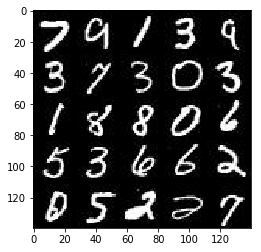

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

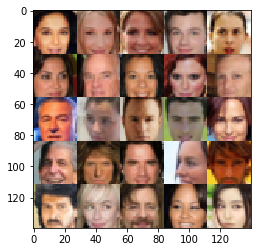

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real    = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z       = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        kernel_size = 4
        filters = 128
 
        # input image is 28x28
        x1 = tf.layers.conv2d(images, filters//4, kernel_size, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #print(relu1.shape)
        # 14x14
        
        x2 = tf.layers.conv2d(relu1, filters//2, kernel_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)
        # 7x7
        
        x3 = tf.layers.conv2d(relu2, filters, kernel_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)
        # 4x4
        
        #flatten
        flat = tf.reshape(relu3, (-1, 4*4*filters))
        logits = tf.layers.dense(flat, 1)
        out    = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # if we are training, don't reuse variables, else do.
    reuse = not(is_train)
        
    with tf.variable_scope('generator', reuse=reuse):
        kernel_size = 4
        filters = 128
        # first fully connected layer
        x1 = tf.layers.dense(z, 4*4*filters)
        # reshape to start the convolution stack
        x1 = tf.reshape(x1, (-1, 4, 4, filters))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(relu1, filters//2, kernel_size, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(relu2, filters//4, kernel_size, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14
        #print(x3.shape)
        
        # output image
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, kernel_size, strides=2, padding='same')
        # 28x28
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # make generator
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # make disctiminator with real input
    d_model_real, d_logits_real = discriminator(input_real)
    # make discriminator with generated input, reuse variables.
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # discriminator loss is sum of d_loss_real + d_loss_fake(genereated)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get variables (weights and bias) to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         show_every=100, print_every=10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # data_shape (batch_size, image_width, image_height, image depth)
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss         = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt           = model_opt(d_loss, g_loss, learning_rate, beta1)
  
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # input from MIST and CelebA is in range -0.5 to 0.5
                # multiply by 2 to get in range -1.0 to 1.0
                batch_images *= 2
                
                # Sample random noice for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                steps += 1
                # show gererator output every no of batches
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                # show loss for every no of batches
                if steps % print_every == 0:
                    train_d_loss      = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_g_loss      = g_loss.eval({input_z: batch_z})
                    print("Epocs {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator loss {:.4f}...".format(train_d_loss),
                          "Generator loss {:.4f}".format(train_g_loss)) 
                    
                  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epocs 1/2... Step 10... Discriminator loss 0.5066... Generator loss 2.1163
Epocs 1/2... Step 20... Discriminator loss 0.4504... Generator loss 2.4856
Epocs 1/2... Step 30... Discriminator loss 0.4392... Generator loss 2.5064
Epocs 1/2... Step 40... Discriminator loss 0.4873... Generator loss 2.4613
Epocs 1/2... Step 50... Discriminator loss 0.3969... Generator loss 3.4676
Epocs 1/2... Step 60... Discriminator loss 0.4246... Generator loss 5.7883
Epocs 1/2... Step 70... Discriminator loss 0.3963... Generator loss 3.5173
Epocs 1/2... Step 80... Discriminator loss 0.4690... Generator loss 3.6524
Epocs 1/2... Step 90... Discriminator loss 0.3987... Generator loss 3.1183


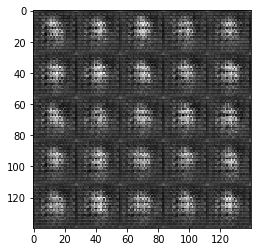

Epocs 1/2... Step 100... Discriminator loss 0.4840... Generator loss 2.1058
Epocs 1/2... Step 110... Discriminator loss 0.5697... Generator loss 1.9194
Epocs 1/2... Step 120... Discriminator loss 0.3903... Generator loss 4.2867
Epocs 1/2... Step 130... Discriminator loss 0.4279... Generator loss 2.8528
Epocs 1/2... Step 140... Discriminator loss 3.6022... Generator loss 15.5782
Epocs 1/2... Step 150... Discriminator loss 0.4139... Generator loss 3.3849
Epocs 1/2... Step 160... Discriminator loss 0.4668... Generator loss 2.7100
Epocs 1/2... Step 170... Discriminator loss 0.4001... Generator loss 3.5647
Epocs 1/2... Step 180... Discriminator loss 0.5037... Generator loss 2.1657
Epocs 1/2... Step 190... Discriminator loss 0.5652... Generator loss 2.3574


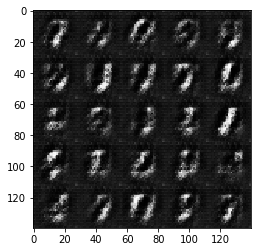

Epocs 1/2... Step 200... Discriminator loss 0.5711... Generator loss 2.9207
Epocs 1/2... Step 210... Discriminator loss 0.5030... Generator loss 2.8208
Epocs 1/2... Step 220... Discriminator loss 0.4119... Generator loss 3.1289
Epocs 1/2... Step 230... Discriminator loss 0.6071... Generator loss 1.9127
Epocs 1/2... Step 240... Discriminator loss 1.0105... Generator loss 4.5775
Epocs 1/2... Step 250... Discriminator loss 0.4901... Generator loss 2.5856
Epocs 1/2... Step 260... Discriminator loss 0.5789... Generator loss 1.8575
Epocs 1/2... Step 270... Discriminator loss 0.5245... Generator loss 2.6932
Epocs 1/2... Step 280... Discriminator loss 0.4326... Generator loss 3.7279
Epocs 1/2... Step 290... Discriminator loss 0.6585... Generator loss 1.6889


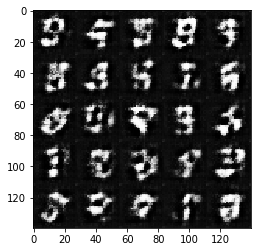

Epocs 1/2... Step 300... Discriminator loss 0.7742... Generator loss 1.4045
Epocs 1/2... Step 310... Discriminator loss 0.5885... Generator loss 1.8201
Epocs 1/2... Step 320... Discriminator loss 0.6157... Generator loss 2.0045
Epocs 1/2... Step 330... Discriminator loss 0.5135... Generator loss 2.4868
Epocs 1/2... Step 340... Discriminator loss 0.5265... Generator loss 2.1527
Epocs 1/2... Step 350... Discriminator loss 0.5932... Generator loss 2.2456
Epocs 1/2... Step 360... Discriminator loss 0.6166... Generator loss 1.6648
Epocs 1/2... Step 370... Discriminator loss 0.5468... Generator loss 2.1536
Epocs 1/2... Step 380... Discriminator loss 0.5931... Generator loss 1.7531
Epocs 1/2... Step 390... Discriminator loss 0.6791... Generator loss 3.8245


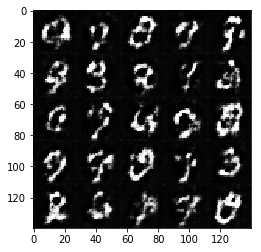

Epocs 1/2... Step 400... Discriminator loss 0.6308... Generator loss 1.6524
Epocs 1/2... Step 410... Discriminator loss 0.5588... Generator loss 2.1612
Epocs 1/2... Step 420... Discriminator loss 0.5715... Generator loss 2.2818
Epocs 1/2... Step 430... Discriminator loss 0.7081... Generator loss 1.5689
Epocs 1/2... Step 440... Discriminator loss 0.6910... Generator loss 1.6232
Epocs 1/2... Step 450... Discriminator loss 0.8142... Generator loss 3.4926
Epocs 1/2... Step 460... Discriminator loss 0.6142... Generator loss 1.9109
Epocs 1/2... Step 470... Discriminator loss 0.5389... Generator loss 2.5746
Epocs 1/2... Step 480... Discriminator loss 0.5981... Generator loss 2.1871
Epocs 1/2... Step 490... Discriminator loss 0.6494... Generator loss 1.7447


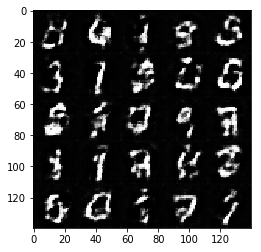

Epocs 1/2... Step 500... Discriminator loss 0.6387... Generator loss 2.0597
Epocs 1/2... Step 510... Discriminator loss 0.6899... Generator loss 2.2581
Epocs 1/2... Step 520... Discriminator loss 0.5815... Generator loss 2.6005
Epocs 1/2... Step 530... Discriminator loss 0.9756... Generator loss 0.9145
Epocs 1/2... Step 540... Discriminator loss 0.7016... Generator loss 1.4344
Epocs 1/2... Step 550... Discriminator loss 0.8258... Generator loss 1.1369
Epocs 1/2... Step 560... Discriminator loss 0.8138... Generator loss 2.6659
Epocs 1/2... Step 570... Discriminator loss 0.7205... Generator loss 2.4905
Epocs 1/2... Step 580... Discriminator loss 0.6763... Generator loss 2.0032
Epocs 1/2... Step 590... Discriminator loss 0.6731... Generator loss 1.7179


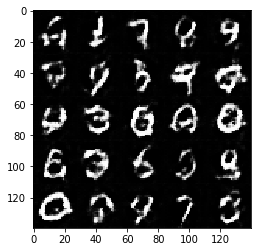

Epocs 1/2... Step 600... Discriminator loss 0.6951... Generator loss 1.4810
Epocs 1/2... Step 610... Discriminator loss 0.7902... Generator loss 1.3408
Epocs 1/2... Step 620... Discriminator loss 0.7161... Generator loss 1.4193
Epocs 1/2... Step 630... Discriminator loss 0.6640... Generator loss 2.2403
Epocs 1/2... Step 640... Discriminator loss 0.7785... Generator loss 2.3891
Epocs 1/2... Step 650... Discriminator loss 0.7360... Generator loss 1.4857
Epocs 1/2... Step 660... Discriminator loss 0.8518... Generator loss 1.2007
Epocs 1/2... Step 670... Discriminator loss 0.8842... Generator loss 1.0278
Epocs 1/2... Step 680... Discriminator loss 0.5983... Generator loss 2.6379
Epocs 1/2... Step 690... Discriminator loss 0.7126... Generator loss 1.5414


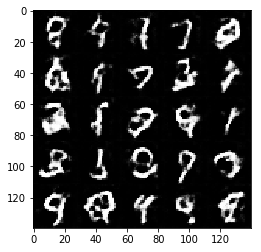

Epocs 1/2... Step 700... Discriminator loss 2.9255... Generator loss 4.7499
Epocs 1/2... Step 710... Discriminator loss 0.8565... Generator loss 1.0756
Epocs 1/2... Step 720... Discriminator loss 0.9129... Generator loss 1.0089
Epocs 1/2... Step 730... Discriminator loss 0.9878... Generator loss 0.8810
Epocs 1/2... Step 740... Discriminator loss 0.7196... Generator loss 1.5319
Epocs 1/2... Step 750... Discriminator loss 0.6981... Generator loss 1.6353
Epocs 1/2... Step 760... Discriminator loss 0.6776... Generator loss 1.6748
Epocs 1/2... Step 770... Discriminator loss 0.6838... Generator loss 1.7742
Epocs 1/2... Step 780... Discriminator loss 0.6998... Generator loss 1.5142
Epocs 1/2... Step 790... Discriminator loss 1.9488... Generator loss 0.2980


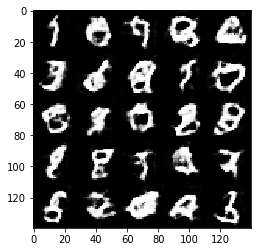

Epocs 1/2... Step 800... Discriminator loss 1.2999... Generator loss 2.4155
Epocs 1/2... Step 810... Discriminator loss 0.8375... Generator loss 1.2676
Epocs 1/2... Step 820... Discriminator loss 0.8083... Generator loss 1.2949
Epocs 1/2... Step 830... Discriminator loss 0.6747... Generator loss 1.6750
Epocs 1/2... Step 840... Discriminator loss 1.2874... Generator loss 2.7611
Epocs 1/2... Step 850... Discriminator loss 0.7812... Generator loss 2.0391
Epocs 1/2... Step 860... Discriminator loss 0.7533... Generator loss 1.3634
Epocs 1/2... Step 870... Discriminator loss 0.7198... Generator loss 1.4672
Epocs 1/2... Step 880... Discriminator loss 0.7335... Generator loss 2.2864
Epocs 1/2... Step 890... Discriminator loss 0.6447... Generator loss 2.0316


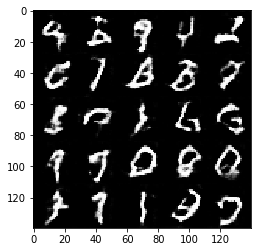

Epocs 1/2... Step 900... Discriminator loss 0.7723... Generator loss 1.3853
Epocs 1/2... Step 910... Discriminator loss 1.9737... Generator loss 2.8423
Epocs 1/2... Step 920... Discriminator loss 0.7581... Generator loss 1.4461
Epocs 1/2... Step 930... Discriminator loss 0.6830... Generator loss 1.5989
Epocs 2/2... Step 940... Discriminator loss 0.8952... Generator loss 1.0054
Epocs 2/2... Step 950... Discriminator loss 0.9202... Generator loss 0.9835
Epocs 2/2... Step 960... Discriminator loss 0.6672... Generator loss 2.0892
Epocs 2/2... Step 970... Discriminator loss 0.5829... Generator loss 1.9822
Epocs 2/2... Step 980... Discriminator loss 1.3436... Generator loss 0.6278
Epocs 2/2... Step 990... Discriminator loss 0.7219... Generator loss 1.5142


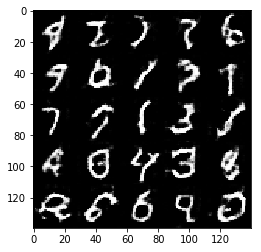

Epocs 2/2... Step 1000... Discriminator loss 0.7416... Generator loss 1.3590
Epocs 2/2... Step 1010... Discriminator loss 1.3432... Generator loss 3.2614
Epocs 2/2... Step 1020... Discriminator loss 0.6575... Generator loss 1.7184
Epocs 2/2... Step 1030... Discriminator loss 0.7326... Generator loss 1.3924
Epocs 2/2... Step 1040... Discriminator loss 0.7458... Generator loss 1.3124
Epocs 2/2... Step 1050... Discriminator loss 1.7661... Generator loss 0.4152
Epocs 2/2... Step 1060... Discriminator loss 0.9970... Generator loss 0.8818
Epocs 2/2... Step 1070... Discriminator loss 0.7871... Generator loss 1.2377
Epocs 2/2... Step 1080... Discriminator loss 0.6997... Generator loss 1.9726
Epocs 2/2... Step 1090... Discriminator loss 0.8563... Generator loss 1.0677


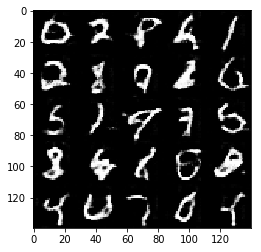

Epocs 2/2... Step 1100... Discriminator loss 0.7242... Generator loss 1.5783
Epocs 2/2... Step 1110... Discriminator loss 0.6635... Generator loss 1.5326
Epocs 2/2... Step 1120... Discriminator loss 0.7494... Generator loss 1.4027
Epocs 2/2... Step 1130... Discriminator loss 1.1428... Generator loss 0.7157
Epocs 2/2... Step 1140... Discriminator loss 2.4045... Generator loss 0.2281
Epocs 2/2... Step 1150... Discriminator loss 0.6970... Generator loss 1.4588
Epocs 2/2... Step 1160... Discriminator loss 0.6169... Generator loss 1.8988
Epocs 2/2... Step 1170... Discriminator loss 0.6558... Generator loss 1.5792
Epocs 2/2... Step 1180... Discriminator loss 0.6521... Generator loss 2.4960
Epocs 2/2... Step 1190... Discriminator loss 1.3799... Generator loss 0.5794


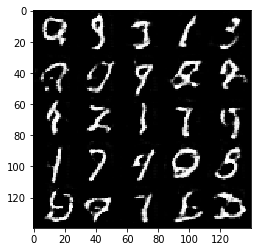

Epocs 2/2... Step 1200... Discriminator loss 0.7661... Generator loss 1.2665
Epocs 2/2... Step 1210... Discriminator loss 0.6279... Generator loss 1.7916
Epocs 2/2... Step 1220... Discriminator loss 0.7116... Generator loss 1.4347
Epocs 2/2... Step 1230... Discriminator loss 1.1621... Generator loss 0.7178
Epocs 2/2... Step 1240... Discriminator loss 1.0197... Generator loss 0.8846
Epocs 2/2... Step 1250... Discriminator loss 0.9951... Generator loss 0.8935
Epocs 2/2... Step 1260... Discriminator loss 0.6699... Generator loss 1.5576
Epocs 2/2... Step 1270... Discriminator loss 0.8214... Generator loss 2.0493
Epocs 2/2... Step 1280... Discriminator loss 0.7301... Generator loss 1.3512
Epocs 2/2... Step 1290... Discriminator loss 1.1433... Generator loss 0.7348


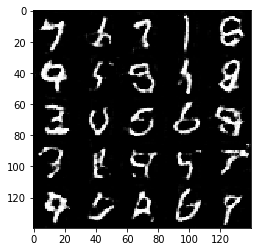

Epocs 2/2... Step 1300... Discriminator loss 0.9443... Generator loss 1.0280
Epocs 2/2... Step 1310... Discriminator loss 0.6976... Generator loss 1.4323
Epocs 2/2... Step 1320... Discriminator loss 0.7606... Generator loss 1.3004
Epocs 2/2... Step 1330... Discriminator loss 0.7352... Generator loss 1.4043
Epocs 2/2... Step 1340... Discriminator loss 0.9160... Generator loss 2.1309
Epocs 2/2... Step 1350... Discriminator loss 0.6610... Generator loss 2.3559
Epocs 2/2... Step 1360... Discriminator loss 0.6370... Generator loss 1.6598
Epocs 2/2... Step 1370... Discriminator loss 0.6682... Generator loss 1.5479
Epocs 2/2... Step 1380... Discriminator loss 0.5925... Generator loss 1.8323
Epocs 2/2... Step 1390... Discriminator loss 0.6572... Generator loss 1.6999


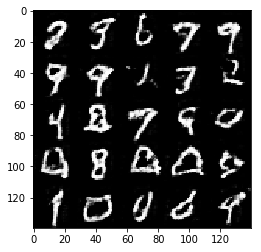

Epocs 2/2... Step 1400... Discriminator loss 0.7605... Generator loss 2.3751
Epocs 2/2... Step 1410... Discriminator loss 0.6277... Generator loss 1.7992
Epocs 2/2... Step 1420... Discriminator loss 0.5596... Generator loss 2.3053
Epocs 2/2... Step 1430... Discriminator loss 0.9821... Generator loss 2.4456
Epocs 2/2... Step 1440... Discriminator loss 0.7398... Generator loss 1.4343
Epocs 2/2... Step 1450... Discriminator loss 0.6312... Generator loss 1.6228
Epocs 2/2... Step 1460... Discriminator loss 0.5505... Generator loss 2.1374
Epocs 2/2... Step 1470... Discriminator loss 0.5980... Generator loss 1.7385
Epocs 2/2... Step 1480... Discriminator loss 0.6559... Generator loss 1.8685
Epocs 2/2... Step 1490... Discriminator loss 0.9991... Generator loss 0.8432


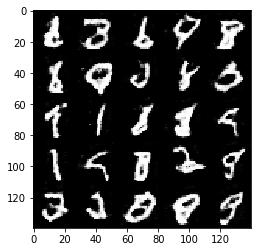

Epocs 2/2... Step 1500... Discriminator loss 0.5466... Generator loss 2.3654
Epocs 2/2... Step 1510... Discriminator loss 0.6997... Generator loss 1.4271
Epocs 2/2... Step 1520... Discriminator loss 0.6452... Generator loss 1.6788
Epocs 2/2... Step 1530... Discriminator loss 1.0667... Generator loss 0.8272
Epocs 2/2... Step 1540... Discriminator loss 0.9740... Generator loss 0.9530
Epocs 2/2... Step 1550... Discriminator loss 0.6495... Generator loss 1.6406
Epocs 2/2... Step 1560... Discriminator loss 0.6033... Generator loss 1.7637
Epocs 2/2... Step 1570... Discriminator loss 0.5641... Generator loss 2.1946
Epocs 2/2... Step 1580... Discriminator loss 0.8959... Generator loss 1.0122
Epocs 2/2... Step 1590... Discriminator loss 0.8844... Generator loss 1.0384


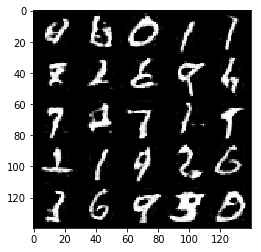

Epocs 2/2... Step 1600... Discriminator loss 0.7252... Generator loss 1.3904
Epocs 2/2... Step 1610... Discriminator loss 1.1925... Generator loss 3.7240
Epocs 2/2... Step 1620... Discriminator loss 0.8552... Generator loss 1.1785
Epocs 2/2... Step 1630... Discriminator loss 0.5528... Generator loss 2.1063
Epocs 2/2... Step 1640... Discriminator loss 0.5487... Generator loss 2.4525
Epocs 2/2... Step 1650... Discriminator loss 0.9257... Generator loss 1.0128
Epocs 2/2... Step 1660... Discriminator loss 0.6396... Generator loss 1.6963
Epocs 2/2... Step 1670... Discriminator loss 1.3564... Generator loss 0.6717
Epocs 2/2... Step 1680... Discriminator loss 0.6343... Generator loss 1.8323
Epocs 2/2... Step 1690... Discriminator loss 0.5331... Generator loss 2.2361


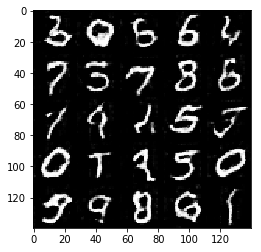

Epocs 2/2... Step 1700... Discriminator loss 0.7107... Generator loss 1.3658
Epocs 2/2... Step 1710... Discriminator loss 1.0532... Generator loss 0.8153
Epocs 2/2... Step 1720... Discriminator loss 0.7292... Generator loss 1.6116
Epocs 2/2... Step 1730... Discriminator loss 0.6477... Generator loss 1.5971
Epocs 2/2... Step 1740... Discriminator loss 0.6555... Generator loss 1.6324
Epocs 2/2... Step 1750... Discriminator loss 0.6682... Generator loss 1.9885
Epocs 2/2... Step 1760... Discriminator loss 0.6846... Generator loss 1.5790
Epocs 2/2... Step 1770... Discriminator loss 0.6785... Generator loss 1.5102
Epocs 2/2... Step 1780... Discriminator loss 1.0014... Generator loss 3.0537
Epocs 2/2... Step 1790... Discriminator loss 0.6496... Generator loss 1.6976


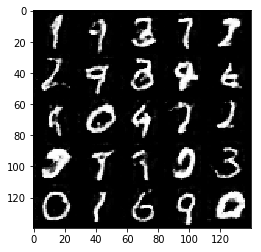

Epocs 2/2... Step 1800... Discriminator loss 0.6526... Generator loss 1.6155
Epocs 2/2... Step 1810... Discriminator loss 0.6113... Generator loss 1.8143
Epocs 2/2... Step 1820... Discriminator loss 0.7040... Generator loss 1.3823
Epocs 2/2... Step 1830... Discriminator loss 0.7121... Generator loss 1.8076
Epocs 2/2... Step 1840... Discriminator loss 0.8010... Generator loss 1.2088
Epocs 2/2... Step 1850... Discriminator loss 0.7303... Generator loss 2.5090
Epocs 2/2... Step 1860... Discriminator loss 0.7796... Generator loss 1.2431
Epocs 2/2... Step 1870... Discriminator loss 0.7482... Generator loss 1.2657


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epocs 1/1... Step 10... Discriminator loss 0.7270... Generator loss 1.5304
Epocs 1/1... Step 20... Discriminator loss 0.5585... Generator loss 2.0559
Epocs 1/1... Step 30... Discriminator loss 0.4710... Generator loss 2.5745
Epocs 1/1... Step 40... Discriminator loss 0.4306... Generator loss 2.9832
Epocs 1/1... Step 50... Discriminator loss 0.4278... Generator loss 2.9469
Epocs 1/1... Step 60... Discriminator loss 0.3632... Generator loss 4.1034
Epocs 1/1... Step 70... Discriminator loss 0.3856... Generator loss 4.8365
Epocs 1/1... Step 80... Discriminator loss 0.4179... Generator loss 5.4893
Epocs 1/1... Step 90... Discriminator loss 0.4029... Generator loss 3.0910


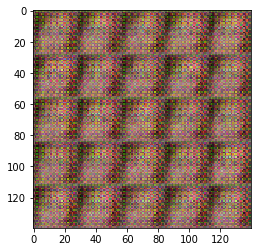

Epocs 1/1... Step 100... Discriminator loss 0.3794... Generator loss 3.9485
Epocs 1/1... Step 110... Discriminator loss 0.4104... Generator loss 3.7170
Epocs 1/1... Step 120... Discriminator loss 0.4352... Generator loss 6.1771
Epocs 1/1... Step 130... Discriminator loss 0.3658... Generator loss 4.6869
Epocs 1/1... Step 140... Discriminator loss 0.3657... Generator loss 3.9050
Epocs 1/1... Step 150... Discriminator loss 0.3685... Generator loss 3.8472
Epocs 1/1... Step 160... Discriminator loss 0.3963... Generator loss 5.1206
Epocs 1/1... Step 170... Discriminator loss 0.5065... Generator loss 2.0190
Epocs 1/1... Step 180... Discriminator loss 0.8051... Generator loss 9.6821
Epocs 1/1... Step 190... Discriminator loss 0.3924... Generator loss 3.7976


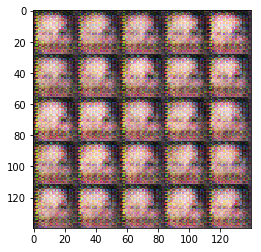

Epocs 1/1... Step 200... Discriminator loss 0.4515... Generator loss 2.4884
Epocs 1/1... Step 210... Discriminator loss 0.3688... Generator loss 4.9661
Epocs 1/1... Step 220... Discriminator loss 0.4050... Generator loss 2.9738
Epocs 1/1... Step 230... Discriminator loss 0.4061... Generator loss 3.4198
Epocs 1/1... Step 240... Discriminator loss 0.4432... Generator loss 3.0561
Epocs 1/1... Step 250... Discriminator loss 0.4014... Generator loss 3.4832
Epocs 1/1... Step 260... Discriminator loss 0.3879... Generator loss 4.6155
Epocs 1/1... Step 270... Discriminator loss 0.4545... Generator loss 4.7811
Epocs 1/1... Step 280... Discriminator loss 0.6520... Generator loss 5.9289
Epocs 1/1... Step 290... Discriminator loss 0.4102... Generator loss 4.6524


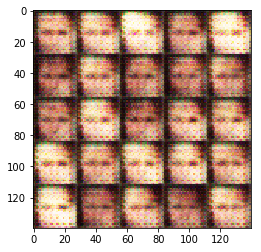

Epocs 1/1... Step 300... Discriminator loss 0.5345... Generator loss 1.8540
Epocs 1/1... Step 310... Discriminator loss 0.4135... Generator loss 3.3655
Epocs 1/1... Step 320... Discriminator loss 0.4390... Generator loss 2.9233
Epocs 1/1... Step 330... Discriminator loss 0.4312... Generator loss 2.9175
Epocs 1/1... Step 340... Discriminator loss 0.4061... Generator loss 3.1360
Epocs 1/1... Step 350... Discriminator loss 0.4093... Generator loss 3.5925
Epocs 1/1... Step 360... Discriminator loss 0.4776... Generator loss 2.4974
Epocs 1/1... Step 370... Discriminator loss 0.5343... Generator loss 2.0767
Epocs 1/1... Step 380... Discriminator loss 0.4639... Generator loss 2.4863
Epocs 1/1... Step 390... Discriminator loss 0.8857... Generator loss 6.2179


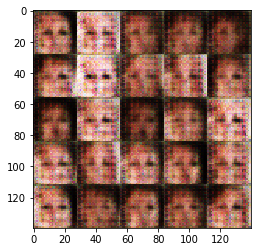

Epocs 1/1... Step 400... Discriminator loss 0.4493... Generator loss 2.7671
Epocs 1/1... Step 410... Discriminator loss 0.5417... Generator loss 3.7381
Epocs 1/1... Step 420... Discriminator loss 0.4761... Generator loss 3.0449
Epocs 1/1... Step 430... Discriminator loss 0.5305... Generator loss 2.9538
Epocs 1/1... Step 440... Discriminator loss 0.5946... Generator loss 1.8526
Epocs 1/1... Step 450... Discriminator loss 1.3766... Generator loss 5.8311
Epocs 1/1... Step 460... Discriminator loss 0.6313... Generator loss 1.6446
Epocs 1/1... Step 470... Discriminator loss 0.5635... Generator loss 2.5167
Epocs 1/1... Step 480... Discriminator loss 0.4717... Generator loss 2.6922
Epocs 1/1... Step 490... Discriminator loss 0.6172... Generator loss 2.5939


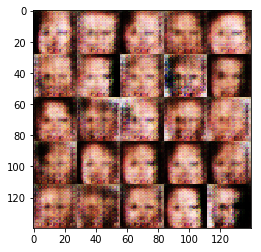

Epocs 1/1... Step 500... Discriminator loss 0.6537... Generator loss 3.0591
Epocs 1/1... Step 510... Discriminator loss 0.6834... Generator loss 1.9879
Epocs 1/1... Step 520... Discriminator loss 0.7957... Generator loss 3.1000
Epocs 1/1... Step 530... Discriminator loss 0.5720... Generator loss 2.3167
Epocs 1/1... Step 540... Discriminator loss 0.6787... Generator loss 1.5828
Epocs 1/1... Step 550... Discriminator loss 0.7710... Generator loss 3.1911
Epocs 1/1... Step 560... Discriminator loss 0.5408... Generator loss 2.1939
Epocs 1/1... Step 570... Discriminator loss 0.5564... Generator loss 2.4837
Epocs 1/1... Step 580... Discriminator loss 0.6046... Generator loss 2.2901
Epocs 1/1... Step 590... Discriminator loss 0.6220... Generator loss 2.6294


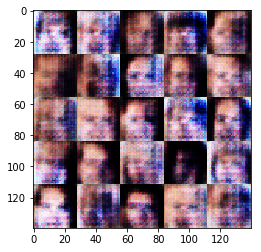

Epocs 1/1... Step 600... Discriminator loss 0.5665... Generator loss 2.1502
Epocs 1/1... Step 610... Discriminator loss 0.5195... Generator loss 2.2344
Epocs 1/1... Step 620... Discriminator loss 0.5095... Generator loss 3.1716
Epocs 1/1... Step 630... Discriminator loss 0.5542... Generator loss 2.3951
Epocs 1/1... Step 640... Discriminator loss 0.6671... Generator loss 1.7985
Epocs 1/1... Step 650... Discriminator loss 0.5284... Generator loss 2.3063
Epocs 1/1... Step 660... Discriminator loss 0.5178... Generator loss 2.8995
Epocs 1/1... Step 670... Discriminator loss 0.6856... Generator loss 2.5345
Epocs 1/1... Step 680... Discriminator loss 0.6948... Generator loss 1.5964
Epocs 1/1... Step 690... Discriminator loss 0.5765... Generator loss 2.4361


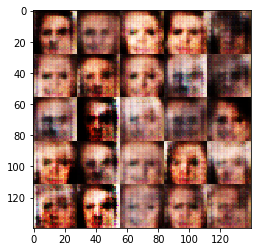

Epocs 1/1... Step 700... Discriminator loss 0.7540... Generator loss 1.5369
Epocs 1/1... Step 710... Discriminator loss 0.5707... Generator loss 2.1725
Epocs 1/1... Step 720... Discriminator loss 0.6510... Generator loss 1.8350
Epocs 1/1... Step 730... Discriminator loss 1.0316... Generator loss 4.3874
Epocs 1/1... Step 740... Discriminator loss 1.1590... Generator loss 4.5236
Epocs 1/1... Step 750... Discriminator loss 0.7257... Generator loss 1.6929
Epocs 1/1... Step 760... Discriminator loss 0.9776... Generator loss 0.9470
Epocs 1/1... Step 770... Discriminator loss 0.5847... Generator loss 2.0431
Epocs 1/1... Step 780... Discriminator loss 0.6152... Generator loss 2.3135
Epocs 1/1... Step 790... Discriminator loss 0.6778... Generator loss 1.5371


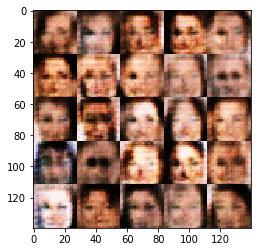

Epocs 1/1... Step 800... Discriminator loss 0.6781... Generator loss 1.8596
Epocs 1/1... Step 810... Discriminator loss 0.9806... Generator loss 0.9359
Epocs 1/1... Step 820... Discriminator loss 0.6533... Generator loss 2.2640
Epocs 1/1... Step 830... Discriminator loss 0.6238... Generator loss 2.2640
Epocs 1/1... Step 840... Discriminator loss 0.8413... Generator loss 1.3464
Epocs 1/1... Step 850... Discriminator loss 0.7257... Generator loss 2.3721
Epocs 1/1... Step 860... Discriminator loss 0.7843... Generator loss 2.9694
Epocs 1/1... Step 870... Discriminator loss 0.7599... Generator loss 1.6029
Epocs 1/1... Step 880... Discriminator loss 0.6636... Generator loss 1.8547
Epocs 1/1... Step 890... Discriminator loss 0.7554... Generator loss 3.1946


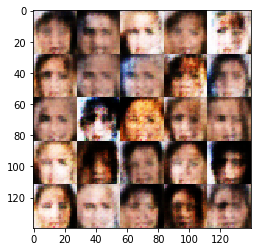

Epocs 1/1... Step 900... Discriminator loss 0.7850... Generator loss 1.6106
Epocs 1/1... Step 910... Discriminator loss 1.0319... Generator loss 1.0920
Epocs 1/1... Step 920... Discriminator loss 0.7886... Generator loss 1.6631
Epocs 1/1... Step 930... Discriminator loss 0.8120... Generator loss 1.2786
Epocs 1/1... Step 940... Discriminator loss 0.7707... Generator loss 1.8783
Epocs 1/1... Step 950... Discriminator loss 0.6914... Generator loss 1.6554
Epocs 1/1... Step 960... Discriminator loss 1.1051... Generator loss 0.8015
Epocs 1/1... Step 970... Discriminator loss 1.0487... Generator loss 1.0315
Epocs 1/1... Step 980... Discriminator loss 0.7786... Generator loss 1.4673
Epocs 1/1... Step 990... Discriminator loss 0.7586... Generator loss 1.4808


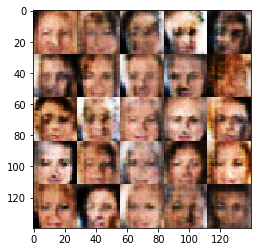

Epocs 1/1... Step 1000... Discriminator loss 0.8907... Generator loss 1.2428
Epocs 1/1... Step 1010... Discriminator loss 1.3442... Generator loss 0.6168
Epocs 1/1... Step 1020... Discriminator loss 0.7160... Generator loss 1.7732
Epocs 1/1... Step 1030... Discriminator loss 0.7287... Generator loss 1.5025
Epocs 1/1... Step 1040... Discriminator loss 0.8281... Generator loss 1.3178
Epocs 1/1... Step 1050... Discriminator loss 0.9563... Generator loss 1.0764
Epocs 1/1... Step 1060... Discriminator loss 0.8198... Generator loss 2.2427
Epocs 1/1... Step 1070... Discriminator loss 0.8013... Generator loss 1.9495
Epocs 1/1... Step 1080... Discriminator loss 0.8762... Generator loss 1.1042
Epocs 1/1... Step 1090... Discriminator loss 0.8057... Generator loss 1.3999


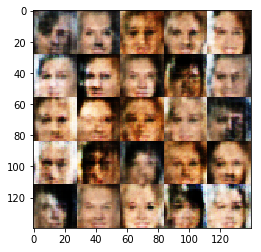

Epocs 1/1... Step 1100... Discriminator loss 1.4158... Generator loss 3.4918
Epocs 1/1... Step 1110... Discriminator loss 0.9344... Generator loss 2.1378
Epocs 1/1... Step 1120... Discriminator loss 0.6586... Generator loss 2.0669
Epocs 1/1... Step 1130... Discriminator loss 0.7463... Generator loss 1.7059
Epocs 1/1... Step 1140... Discriminator loss 0.7996... Generator loss 2.4525
Epocs 1/1... Step 1150... Discriminator loss 1.2497... Generator loss 0.7114
Epocs 1/1... Step 1160... Discriminator loss 0.7236... Generator loss 1.9581
Epocs 1/1... Step 1170... Discriminator loss 0.9882... Generator loss 0.9954
Epocs 1/1... Step 1180... Discriminator loss 0.7316... Generator loss 1.4398
Epocs 1/1... Step 1190... Discriminator loss 0.7649... Generator loss 2.3875


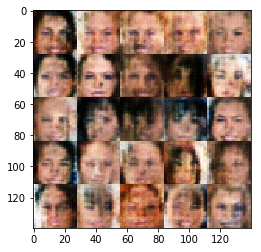

Epocs 1/1... Step 1200... Discriminator loss 1.0411... Generator loss 2.8527
Epocs 1/1... Step 1210... Discriminator loss 0.7792... Generator loss 1.9044
Epocs 1/1... Step 1220... Discriminator loss 0.8921... Generator loss 1.1799
Epocs 1/1... Step 1230... Discriminator loss 0.7005... Generator loss 1.5955
Epocs 1/1... Step 1240... Discriminator loss 0.9245... Generator loss 1.0203
Epocs 1/1... Step 1250... Discriminator loss 0.6966... Generator loss 1.7729
Epocs 1/1... Step 1260... Discriminator loss 0.9486... Generator loss 1.2909
Epocs 1/1... Step 1270... Discriminator loss 1.4357... Generator loss 0.5304
Epocs 1/1... Step 1280... Discriminator loss 0.9086... Generator loss 1.6193
Epocs 1/1... Step 1290... Discriminator loss 0.7657... Generator loss 1.5340


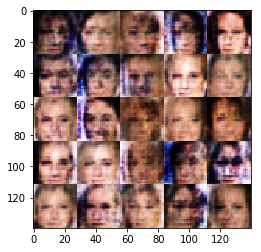

Epocs 1/1... Step 1300... Discriminator loss 0.7999... Generator loss 1.3157
Epocs 1/1... Step 1310... Discriminator loss 0.7806... Generator loss 1.8522
Epocs 1/1... Step 1320... Discriminator loss 0.7816... Generator loss 1.4873
Epocs 1/1... Step 1330... Discriminator loss 0.7170... Generator loss 1.9374
Epocs 1/1... Step 1340... Discriminator loss 0.8399... Generator loss 2.5590
Epocs 1/1... Step 1350... Discriminator loss 1.1480... Generator loss 0.7696
Epocs 1/1... Step 1360... Discriminator loss 0.8388... Generator loss 1.4565
Epocs 1/1... Step 1370... Discriminator loss 0.9471... Generator loss 1.0168
Epocs 1/1... Step 1380... Discriminator loss 0.9011... Generator loss 1.1687
Epocs 1/1... Step 1390... Discriminator loss 0.8156... Generator loss 2.8478


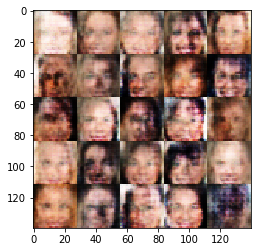

Epocs 1/1... Step 1400... Discriminator loss 0.9351... Generator loss 1.2852
Epocs 1/1... Step 1410... Discriminator loss 0.7765... Generator loss 1.8458
Epocs 1/1... Step 1420... Discriminator loss 0.7939... Generator loss 1.5338
Epocs 1/1... Step 1430... Discriminator loss 0.7040... Generator loss 1.9631
Epocs 1/1... Step 1440... Discriminator loss 0.8499... Generator loss 1.1916
Epocs 1/1... Step 1450... Discriminator loss 0.6123... Generator loss 2.1844
Epocs 1/1... Step 1460... Discriminator loss 1.1912... Generator loss 0.7579
Epocs 1/1... Step 1470... Discriminator loss 0.6938... Generator loss 1.8809
Epocs 1/1... Step 1480... Discriminator loss 0.7219... Generator loss 1.7063
Epocs 1/1... Step 1490... Discriminator loss 0.7209... Generator loss 1.9276


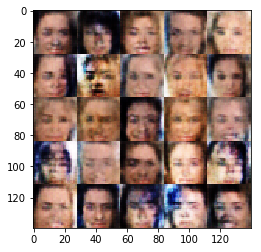

Epocs 1/1... Step 1500... Discriminator loss 0.7867... Generator loss 1.6684
Epocs 1/1... Step 1510... Discriminator loss 0.9187... Generator loss 1.0129
Epocs 1/1... Step 1520... Discriminator loss 0.7526... Generator loss 1.7086
Epocs 1/1... Step 1530... Discriminator loss 0.9916... Generator loss 2.6484
Epocs 1/1... Step 1540... Discriminator loss 0.8097... Generator loss 1.6810
Epocs 1/1... Step 1550... Discriminator loss 0.6972... Generator loss 1.9744
Epocs 1/1... Step 1560... Discriminator loss 0.8569... Generator loss 1.1264
Epocs 1/1... Step 1570... Discriminator loss 0.7509... Generator loss 1.7119
Epocs 1/1... Step 1580... Discriminator loss 0.7660... Generator loss 1.6701
Epocs 1/1... Step 1590... Discriminator loss 1.0187... Generator loss 1.0176


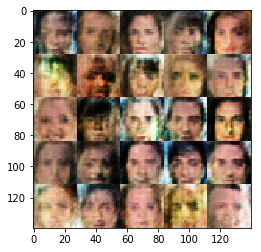

Epocs 1/1... Step 1600... Discriminator loss 0.9273... Generator loss 1.2332
Epocs 1/1... Step 1610... Discriminator loss 1.0204... Generator loss 2.7251
Epocs 1/1... Step 1620... Discriminator loss 0.7826... Generator loss 1.5421
Epocs 1/1... Step 1630... Discriminator loss 0.8524... Generator loss 1.2311
Epocs 1/1... Step 1640... Discriminator loss 0.7775... Generator loss 1.4481
Epocs 1/1... Step 1650... Discriminator loss 0.8468... Generator loss 1.6960
Epocs 1/1... Step 1660... Discriminator loss 1.0750... Generator loss 0.8403
Epocs 1/1... Step 1670... Discriminator loss 0.8056... Generator loss 2.3753
Epocs 1/1... Step 1680... Discriminator loss 0.7899... Generator loss 2.5444
Epocs 1/1... Step 1690... Discriminator loss 0.9207... Generator loss 1.1333


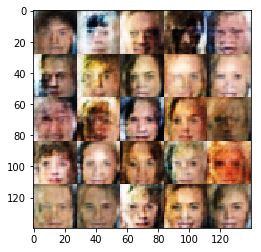

Epocs 1/1... Step 1700... Discriminator loss 0.8240... Generator loss 2.2731
Epocs 1/1... Step 1710... Discriminator loss 0.8105... Generator loss 1.4032
Epocs 1/1... Step 1720... Discriminator loss 0.9054... Generator loss 1.1635
Epocs 1/1... Step 1730... Discriminator loss 0.8798... Generator loss 1.2890
Epocs 1/1... Step 1740... Discriminator loss 0.8525... Generator loss 1.2776
Epocs 1/1... Step 1750... Discriminator loss 1.3794... Generator loss 0.5747
Epocs 1/1... Step 1760... Discriminator loss 0.8351... Generator loss 1.6410
Epocs 1/1... Step 1770... Discriminator loss 0.8093... Generator loss 1.5292
Epocs 1/1... Step 1780... Discriminator loss 0.7496... Generator loss 1.5502
Epocs 1/1... Step 1790... Discriminator loss 0.9218... Generator loss 1.0582


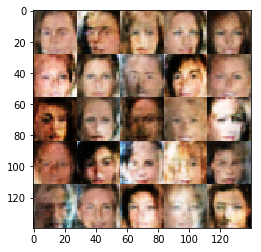

Epocs 1/1... Step 1800... Discriminator loss 0.7682... Generator loss 1.9082
Epocs 1/1... Step 1810... Discriminator loss 1.1010... Generator loss 0.8532
Epocs 1/1... Step 1820... Discriminator loss 0.8012... Generator loss 1.8678
Epocs 1/1... Step 1830... Discriminator loss 0.8354... Generator loss 1.4265
Epocs 1/1... Step 1840... Discriminator loss 0.6877... Generator loss 1.7726
Epocs 1/1... Step 1850... Discriminator loss 0.9894... Generator loss 2.4668
Epocs 1/1... Step 1860... Discriminator loss 0.8059... Generator loss 2.1104
Epocs 1/1... Step 1870... Discriminator loss 0.8979... Generator loss 1.0425
Epocs 1/1... Step 1880... Discriminator loss 0.9415... Generator loss 1.0316
Epocs 1/1... Step 1890... Discriminator loss 0.7329... Generator loss 1.9302


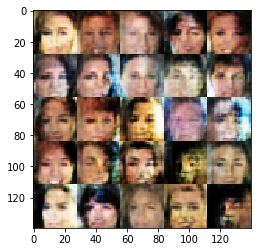

Epocs 1/1... Step 1900... Discriminator loss 1.1811... Generator loss 2.8940
Epocs 1/1... Step 1910... Discriminator loss 0.9476... Generator loss 1.4670
Epocs 1/1... Step 1920... Discriminator loss 0.9306... Generator loss 1.0910
Epocs 1/1... Step 1930... Discriminator loss 0.8040... Generator loss 1.6725
Epocs 1/1... Step 1940... Discriminator loss 0.7564... Generator loss 1.8382
Epocs 1/1... Step 1950... Discriminator loss 0.7327... Generator loss 1.7551
Epocs 1/1... Step 1960... Discriminator loss 1.0600... Generator loss 0.8836
Epocs 1/1... Step 1970... Discriminator loss 0.8688... Generator loss 1.2106
Epocs 1/1... Step 1980... Discriminator loss 0.9381... Generator loss 1.6895
Epocs 1/1... Step 1990... Discriminator loss 0.8719... Generator loss 1.6466


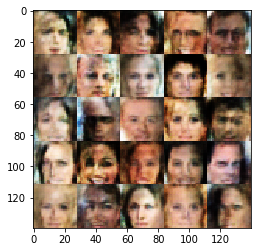

Epocs 1/1... Step 2000... Discriminator loss 1.0005... Generator loss 2.2591
Epocs 1/1... Step 2010... Discriminator loss 0.8313... Generator loss 1.3249
Epocs 1/1... Step 2020... Discriminator loss 1.1909... Generator loss 0.7710
Epocs 1/1... Step 2030... Discriminator loss 0.6835... Generator loss 1.9275
Epocs 1/1... Step 2040... Discriminator loss 0.8619... Generator loss 1.4962
Epocs 1/1... Step 2050... Discriminator loss 0.7364... Generator loss 1.7902
Epocs 1/1... Step 2060... Discriminator loss 0.8197... Generator loss 1.4584
Epocs 1/1... Step 2070... Discriminator loss 1.1564... Generator loss 0.8392
Epocs 1/1... Step 2080... Discriminator loss 0.8564... Generator loss 1.3141
Epocs 1/1... Step 2090... Discriminator loss 0.8793... Generator loss 1.1140


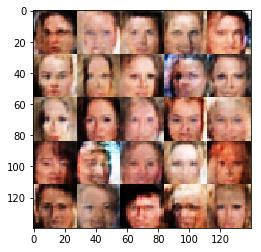

Epocs 1/1... Step 2100... Discriminator loss 0.9801... Generator loss 1.2636
Epocs 1/1... Step 2110... Discriminator loss 1.1187... Generator loss 2.2381
Epocs 1/1... Step 2120... Discriminator loss 0.8510... Generator loss 1.6859
Epocs 1/1... Step 2130... Discriminator loss 0.9771... Generator loss 1.2433
Epocs 1/1... Step 2140... Discriminator loss 0.8374... Generator loss 1.7156
Epocs 1/1... Step 2150... Discriminator loss 0.8665... Generator loss 1.1576
Epocs 1/1... Step 2160... Discriminator loss 1.0319... Generator loss 0.9508
Epocs 1/1... Step 2170... Discriminator loss 0.8123... Generator loss 1.4612
Epocs 1/1... Step 2180... Discriminator loss 1.2825... Generator loss 1.8815
Epocs 1/1... Step 2190... Discriminator loss 0.9124... Generator loss 1.2504


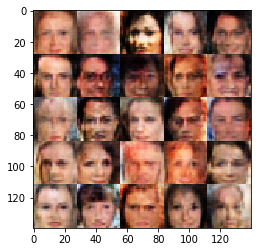

Epocs 1/1... Step 2200... Discriminator loss 0.8115... Generator loss 1.5537
Epocs 1/1... Step 2210... Discriminator loss 1.2231... Generator loss 2.1965
Epocs 1/1... Step 2220... Discriminator loss 0.9617... Generator loss 1.1035
Epocs 1/1... Step 2230... Discriminator loss 1.0660... Generator loss 0.8928
Epocs 1/1... Step 2240... Discriminator loss 0.7974... Generator loss 1.6314
Epocs 1/1... Step 2250... Discriminator loss 1.1729... Generator loss 0.7412
Epocs 1/1... Step 2260... Discriminator loss 0.8277... Generator loss 1.6011
Epocs 1/1... Step 2270... Discriminator loss 0.7724... Generator loss 1.4536
Epocs 1/1... Step 2280... Discriminator loss 0.7797... Generator loss 1.5771
Epocs 1/1... Step 2290... Discriminator loss 0.9799... Generator loss 1.1226


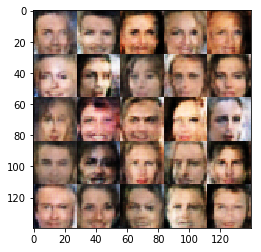

Epocs 1/1... Step 2300... Discriminator loss 0.8629... Generator loss 1.1640
Epocs 1/1... Step 2310... Discriminator loss 0.8514... Generator loss 1.7654
Epocs 1/1... Step 2320... Discriminator loss 1.1264... Generator loss 0.7617
Epocs 1/1... Step 2330... Discriminator loss 0.9393... Generator loss 1.2453
Epocs 1/1... Step 2340... Discriminator loss 0.8925... Generator loss 1.4748
Epocs 1/1... Step 2350... Discriminator loss 0.9298... Generator loss 1.1525
Epocs 1/1... Step 2360... Discriminator loss 0.8977... Generator loss 1.3364
Epocs 1/1... Step 2370... Discriminator loss 0.8167... Generator loss 2.1161
Epocs 1/1... Step 2380... Discriminator loss 0.8744... Generator loss 1.5248
Epocs 1/1... Step 2390... Discriminator loss 0.9121... Generator loss 1.9850


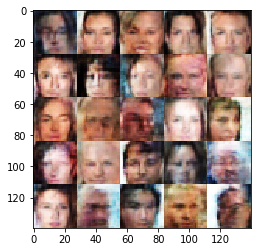

Epocs 1/1... Step 2400... Discriminator loss 0.9661... Generator loss 1.0604
Epocs 1/1... Step 2410... Discriminator loss 0.8230... Generator loss 1.9040
Epocs 1/1... Step 2420... Discriminator loss 0.9012... Generator loss 1.8014
Epocs 1/1... Step 2430... Discriminator loss 0.9164... Generator loss 1.1100
Epocs 1/1... Step 2440... Discriminator loss 0.9678... Generator loss 1.0568
Epocs 1/1... Step 2450... Discriminator loss 1.0955... Generator loss 0.9324
Epocs 1/1... Step 2460... Discriminator loss 0.7837... Generator loss 2.0681
Epocs 1/1... Step 2470... Discriminator loss 1.0764... Generator loss 0.8404
Epocs 1/1... Step 2480... Discriminator loss 1.0793... Generator loss 0.8862
Epocs 1/1... Step 2490... Discriminator loss 0.9873... Generator loss 1.2111


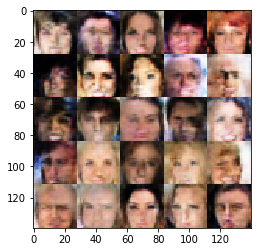

Epocs 1/1... Step 2500... Discriminator loss 0.8259... Generator loss 1.4941
Epocs 1/1... Step 2510... Discriminator loss 1.0167... Generator loss 1.3176
Epocs 1/1... Step 2520... Discriminator loss 0.9017... Generator loss 1.2482
Epocs 1/1... Step 2530... Discriminator loss 0.9876... Generator loss 1.0675
Epocs 1/1... Step 2540... Discriminator loss 0.9761... Generator loss 0.9757
Epocs 1/1... Step 2550... Discriminator loss 1.0943... Generator loss 2.1018


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.